In [ ]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(
  ["git", "clone", REPO_URL, str(REPO_DIR)],
  check=True
)

USE_CLEAN = False  # <--- Set True to remove existing environment
opts = "--clean" if USE_CLEAN else ""

get_ipython().run_line_magic(
    "run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts}"
)

🔧 FEniCSx Setup Configuration
PETSc type      : real
Clean install   : False

⚠️  Google Drive not mounted — using local cache (/content)

🔧 Installing FEniCSx environment...

🔍 Verifying PETSc type...
✅ Installed: Real PETSc (float64)

✨ Loading FEniCSx Jupyter magic... %%fenicsx registered

✅ FEniCSx setup complete!

Next steps:
  1. Run %%fenicsx --info to verify installation
  2. Use %%fenicsx in cells to run FEniCSx code
  3. Use -np N for parallel execution (e.g., %%fenicsx -np 4)

📌 Note: Real PETSc is installed
   - Recommended for most FEM problems
   - For complex problems, reinstall with --complex


---

In [ ]:
%%fenicsx

import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

import basix.ufl
import dolfinx
import ufl


# ============================================================================
# Error computation functions
# ============================================================================

def l2_error(u_h, exact):
    """Compute the error in the L2 norm."""
    error_form = dolfinx.fem.form(
        ufl.inner(u_h - exact, u_h - exact) * ufl.dx
    )
    error_local = dolfinx.fem.assemble_scalar(error_form)
    error_global = u_h.function_space.mesh.comm.allreduce(
        error_local, op=MPI.SUM)
    return np.sqrt(error_global).real


def hcurl_error(u_h, exact):
    """Compute the error in the Hcurl norm."""
    error_form = dolfinx.fem.form(
        ufl.inner(u_h - exact, u_h - exact) * ufl.dx +
        ufl.inner(ufl.curl(u_h - exact), ufl.curl(u_h - exact)) * ufl.dx
    )
    error_local = dolfinx.fem.assemble_scalar(error_form)
    error_global = u_h.function_space.mesh.comm.allreduce(
        error_local, op=MPI.SUM)
    return np.sqrt(error_global).real


def hdiv_error(u_h, exact):
    """Compute the error in the Hdiv norm."""
    error_form = dolfinx.fem.form(
        ufl.inner(u_h - exact, u_h - exact) * ufl.dx +
        ufl.inner(ufl.div(u_h - exact), ufl.div(u_h - exact)) * ufl.dx
    )
    error_local = dolfinx.fem.assemble_scalar(error_form)
    error_global = u_h.function_space.mesh.comm.allreduce(
        error_local, op=MPI.SUM)
    return np.sqrt(error_global).real


def max_cell_size(mesh):
    """Get the maximum cell size (h) in a mesh."""
    tdim = mesh.topology.dim
    num_cells_local = mesh.topology.index_map(tdim).size_local
    h_local = dolfinx.cpp.mesh.h(
        mesh._cpp_object, tdim,
        np.arange(num_cells_local, dtype=np.int32))
    return mesh.comm.allreduce(np.max(h_local), op=MPI.MAX)


def print_table(headers, data, widths=None):
    """Print a nicely formatted table."""
    if widths is None:
        widths = [max(len(str(row[i])) for row in [headers] + data) + 2
                  for i in range(len(headers))]

    header_line = " | ".join(f"{h:^{w}}" for h, w in zip(headers, widths))
    print(header_line)
    print("-" * len(header_line))

    for row in data:
        row_line = " | ".join(
            f"{val:^{w}.6e}" if isinstance(val, float) else f"{val:^{w}}"
            for val, w in zip(row, widths)
        )
        print(row_line)


# ============================================================================
# Custom element definition
# ============================================================================

def point_eval_element(degree: int):
    """Create a Nedelec element based on point evaluations."""
    wcoeffs = basix.ufl.element(
        basix.ElementFamily.N1E, basix.CellType.tetrahedron, degree,
        basix.LagrangeVariant.equispaced)._wcoeffs

    geom = basix.geometry(basix.CellType.tetrahedron)
    top = basix.topology(basix.CellType.tetrahedron)
    x = [[], [], [], []]
    M = [[], [], [], []]

    # Vertices
    for _ in top[0]:
        x[0].append(np.zeros([0, 3]))
        M[0].append(np.zeros([0, 3, 0, 1]))

    # Edges
    pts = basix.create_lattice(
        basix.CellType.interval, degree - 1,
        basix.LatticeType.equispaced, True)
    for e in top[1]:
        v0 = geom[e[0]]
        v1 = geom[e[1]]
        edge_pts = np.array([v0 + p * (v1 - v0) for p in pts])
        x[1].append(edge_pts)

        mat = np.zeros((len(pts), 3, len(pts), 1))
        for i, c in enumerate(v1 - v0):
            mat[:, i, :, 0] = c * np.eye(len(pts))
        M[1].append(mat)

    # Faces
    if degree == 1:
        for f in top[2]:
            x[2].append(np.zeros([0, 3]))
            M[2].append(np.zeros([0, 3, 0, 1]))
    else:
        pts = basix.create_lattice(
            basix.CellType.triangle, degree + 1,
            basix.LatticeType.equispaced, False)
        for f in top[2]:
            v0 = geom[f[0]]
            v1 = geom[f[1]]
            v2 = geom[f[2]]
            face_pts = np.array(
                [v0 + p[0] * (v1 - v0) + p[1] * (v2 - v0) for p in pts])
            x[2].append(face_pts)

            mat = np.zeros((2 * len(pts), 3, len(pts), 1))
            for i, c in enumerate(v1 - v0):
                mat[:len(pts), i, :, 0] = c * np.eye(len(pts))
            for i, c in enumerate(v2 - v0):
                mat[len(pts):, i, :, 0] = c * np.eye(len(pts))
            M[2].append(mat)

    # Interior
    if degree <= 2:
        x[3].append(np.zeros([0, 3]))
        M[3].append(np.zeros([0, 3, 0, 1]))
    else:
        pts = basix.create_lattice(
            basix.CellType.tetrahedron, degree + 1,
            basix.LatticeType.equispaced, False)
        x[3].append(pts)

        mat = np.zeros((3 * len(pts), 3, len(pts), 1))
        mat[:len(pts), 0, :, 0] = np.eye(len(pts))
        mat[len(pts):2 * len(pts), 1, :, 0] = np.eye(len(pts))
        mat[2 * len(pts):, 2, :, 0] = np.eye(len(pts))
        M[3].append(mat)

    return basix.ufl.custom_element(
        basix.CellType.tetrahedron, [3], wcoeffs, x, M, 0,
        basix.MapType.covariantPiola, basix.SobolevSpace.HCurl,
        False, degree - 1, degree)


# ============================================================================
# Create mesh
# ============================================================================

msh = dolfinx.mesh.create_unit_cube(
    MPI.COMM_WORLD, 5, 5, 5, dolfinx.mesh.CellType.tetrahedron)


# ============================================================================
# 1. Lagrange interpolation error
# ============================================================================

print("\n" + "=" * 70)
print("LAGRANGE INTERPOLATION ERROR")
print("=" * 70)

def f(x):
    return np.cos(20 * x[0] * x[1] * x[2])

def ufl_f(x):
    return ufl.cos(20 * x[0] * x[1] * x[2])

# p-refinement
print("\n--- p-refinement (increasing polynomial degree) ---")
x = ufl.SpatialCoordinate(msh)
degrees = []
errors = []

for degree in range(1, 9):
    lagrange_degree = dolfinx.fem.functionspace(msh, ("Lagrange", degree))
    f_h = dolfinx.fem.Function(lagrange_degree)
    f_h.interpolate(f)
    exact_f = ufl_f(x)

    degrees.append(degree)
    errors.append(l2_error(f_h, exact_f))

data = [[d, e] for d, e in zip(degrees, errors)]
print_table(["Degree", "L2 Error"], data)

# h-refinement
print("\n--- h-refinement (decreasing mesh size) ---")
hs = []
errors = []

for i in range(1, 7):
    n = 2 ** i
    mesh_h = dolfinx.mesh.create_unit_cube(
        MPI.COMM_WORLD, n, n, n, dolfinx.mesh.CellType.tetrahedron)
    h = max_cell_size(mesh_h)
    lagrange_h = dolfinx.fem.functionspace(mesh_h, ("Lagrange", 3))
    f_h = dolfinx.fem.Function(lagrange_h)
    f_h.interpolate(f)
    x = ufl.SpatialCoordinate(mesh_h)
    exact_f = ufl_f(x)

    hs.append(h)
    errors.append(l2_error(f_h, exact_f))

data = [[h, e] for h, e in zip(hs, errors)]
print_table(["h", "L2 Error"], data)


# ============================================================================
# 2. Nedelec interpolation error
# ============================================================================

print("\n" + "=" * 70)
print("NEDELEC INTERPOLATION ERROR")
print("=" * 70)

def g(x):
    return np.array([np.sin(8 * x[0]), 2 ** x[1] * np.cos(3 * x[2]), x[0]])

def ufl_g(x):
    return ufl.as_vector([
        ufl.sin(8 * x[0]), 2 ** x[1] * ufl.cos(3 * x[2]), x[0]])

# p-refinement
print("\n--- p-refinement (increasing polynomial degree) ---")
x = ufl.SpatialCoordinate(msh)
nedelec_p_degrees = []
nedelec_p_l2 = []
nedelec_p_hcurl = []

for degree in range(1, 9):
    nedelec_degree = dolfinx.fem.functionspace(msh, ("N1curl", degree))
    g_h = dolfinx.fem.Function(nedelec_degree)
    g_h.interpolate(g)
    exact_g = ufl_g(x)

    nedelec_p_degrees.append(degree)
    nedelec_p_l2.append(l2_error(g_h, exact_g))
    nedelec_p_hcurl.append(hcurl_error(g_h, exact_g))

data = [[d, l2e, hce] for d, l2e, hce in
        zip(nedelec_p_degrees, nedelec_p_l2, nedelec_p_hcurl)]
print_table(["Degree", "L2 Error", "Hcurl Error"], data)

# h-refinement
print("\n--- h-refinement (decreasing mesh size) ---")
nedelec_h_hs = []
nedelec_h_l2 = []
nedelec_h_hcurl = []

for i in range(1, 7):
    n = 2 ** i
    mesh_h = dolfinx.mesh.create_unit_cube(
        MPI.COMM_WORLD, n, n, n, dolfinx.mesh.CellType.tetrahedron)
    h = max_cell_size(mesh_h)
    nedelec_h = dolfinx.fem.functionspace(mesh_h, ("N1curl", 3))
    g_h = dolfinx.fem.Function(nedelec_h)
    g_h.interpolate(g)
    x = ufl.SpatialCoordinate(mesh_h)
    exact_g = ufl_g(x)

    nedelec_h_hs.append(h)
    nedelec_h_l2.append(l2_error(g_h, exact_g))
    nedelec_h_hcurl.append(hcurl_error(g_h, exact_g))

data = [[h, l2e, hce] for h, l2e, hce in
        zip(nedelec_h_hs, nedelec_h_l2, nedelec_h_hcurl)]
print_table(["h", "L2 Error", "Hcurl Error"], data)


# ============================================================================
# 3. De Rham complex property
# ============================================================================

print("\n" + "=" * 70)
print("DE RHAM COMPLEX: CURL OF NEDELEC FUNCTION")
print("=" * 70)

nedelec = dolfinx.fem.functionspace(msh, ("N1curl", 3))
g_h = dolfinx.fem.Function(nedelec)
g_h.interpolate(g)
rt = dolfinx.fem.functionspace(msh, ("RT", 3))
expression = dolfinx.fem.Expression(
    ufl.curl(g_h), rt.element.interpolation_points)
curl_g_h = dolfinx.fem.Function(rt)
curl_g_h.interpolate(expression)

x = ufl.SpatialCoordinate(msh)
curl_g = ufl.curl(ufl_g(x))

print(f"\nL2 error of curl (Nedelec degree 3): {l2_error(curl_g_h, curl_g):.6e}")

# p-refinement
print("\n--- p-refinement ---")
degrees = []
errors = []

for degree in range(1, 9):
    nedelec_degree = dolfinx.fem.functionspace(msh, ("N1curl", degree))
    g_h = dolfinx.fem.Function(nedelec_degree)
    g_h.interpolate(g)
    rt_degree = dolfinx.fem.functionspace(msh, ("RT", degree))
    expression = dolfinx.fem.Expression(
        ufl.curl(g_h), rt_degree.element.interpolation_points)
    curl_g_h = dolfinx.fem.Function(rt_degree)
    curl_g_h.interpolate(expression)

    degrees.append(degree)
    errors.append(l2_error(curl_g_h, curl_g))

data = [[d, e] for d, e in zip(degrees, errors)]
print_table(["Degree", "Hdiv Error"], data)


# ============================================================================
# 4. Comparison: Point evaluation vs Integral moment Nedelec
# ============================================================================

print("\n" + "=" * 70)
print("POINT EVALUATION vs INTEGRAL MOMENT NEDELEC")
print("=" * 70)

x = ufl.SpatialCoordinate(msh)
exact = ufl_g(x)

# L2 norm comparison
print("\n--- L2 norm comparison ---")
comp_degrees = []
comp_pt_l2 = []
comp_int_l2 = []

for degree in range(1, 9):
    # Point evaluation
    space = dolfinx.fem.functionspace(msh, point_eval_element(degree))
    g_h = dolfinx.fem.Function(space)
    g_h.interpolate(g)
    pt_error = l2_error(g_h, exact)

    # Integral moment
    space = dolfinx.fem.functionspace(msh, ("N1curl", degree))
    g_h = dolfinx.fem.Function(space)
    g_h.interpolate(g)
    int_error = l2_error(g_h, exact)

    comp_degrees.append(degree)
    comp_pt_l2.append(pt_error)
    comp_int_l2.append(int_error)

data = [[d, pte, inte] for d, pte, inte in zip(comp_degrees, comp_pt_l2, comp_int_l2)]
print_table(["Degree", "Point Eval (L2)", "Integral Moment (L2)"], data)

# Hcurl norm comparison
print("\n--- Hcurl norm comparison ---")
comp_pt_hcurl = []
comp_int_hcurl = []

for degree in range(1, 9):
    # Point evaluation
    space = dolfinx.fem.functionspace(msh, point_eval_element(degree))
    g_h = dolfinx.fem.Function(space)
    g_h.interpolate(g)
    pt_error = hcurl_error(g_h, exact)

    # Integral moment
    space = dolfinx.fem.functionspace(msh, ("N1curl", degree))
    g_h = dolfinx.fem.Function(space)
    g_h.interpolate(g)
    int_error = hcurl_error(g_h, exact)

    comp_pt_hcurl.append(pt_error)
    comp_int_hcurl.append(int_error)

data = [[d, pte, inte] for d, pte, inte in
        zip(comp_degrees, comp_pt_hcurl, comp_int_hcurl)]
print_table(["Degree", "Point Eval (Hcurl)", "Integral Moment (Hcurl)"], data)


# ============================================================================
# Plotting results
# ============================================================================

print("\n" + "=" * 70)
print("GENERATING PLOTS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Nedelec p-refinement (both norms)
ax = axes[0, 0]
degrees_arr = np.array(nedelec_p_degrees)
ax.semilogy(degrees_arr, nedelec_p_l2, 'o-', label='L2 norm', linewidth=2, markersize=8)
ax.semilogy(degrees_arr, nedelec_p_hcurl, 's-', label='Hcurl norm', linewidth=2, markersize=8)
ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Nedelec: p-refinement', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 2: Nedelec h-refinement (both norms)
ax = axes[0, 1]
hs_arr = np.array(nedelec_h_hs)
ax.loglog(hs_arr, nedelec_h_l2, 'o-', label='L2 norm', linewidth=2, markersize=8)
ax.loglog(hs_arr, nedelec_h_hcurl, 's-', label='Hcurl norm', linewidth=2, markersize=8)
ax.loglog(hs_arr, hs_arr**3 * nedelec_h_l2[0] / hs_arr[0]**3,
          '--', alpha=0.5, label='O(h³)')
ax.set_xlabel('Mesh Size h', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Nedelec: h-refinement', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 3: Point eval vs Integral moment (L2)
ax = axes[1, 0]
comp_degrees_arr = np.array(comp_degrees)
ax.semilogy(comp_degrees_arr, comp_pt_l2, 'o-', label='Point Evaluation',
            linewidth=2, markersize=8)
ax.semilogy(comp_degrees_arr, comp_int_l2, 's-', label='Integral Moment',
            linewidth=2, markersize=8)
ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('L2 Error', fontsize=12)
ax.set_title('Nedelec DOF Comparison (L2)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 4: Point eval vs Integral moment (Hcurl)
ax = axes[1, 1]
ax.semilogy(comp_degrees_arr, comp_pt_hcurl, 'o-', label='Point Evaluation',
            linewidth=2, markersize=8)
ax.semilogy(comp_degrees_arr, comp_int_hcurl, 's-', label='Integral Moment',
            linewidth=2, markersize=8)
ax.set_xlabel('Polynomial Degree', fontsize=12)
ax.set_ylabel('Hcurl Error', fontsize=12)
ax.set_title('Nedelec DOF Comparison (Hcurl)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('interpolation_errors.png', dpi=150, bbox_inches='tight')
print("\nPlot saved as 'interpolation_errors.png'")
plt.close()

print("\n" + "=" * 70)
print("COMPLETED")
print("=" * 70)


LAGRANGE INTERPOLATION ERROR

--- p-refinement (increasing polynomial degree) ---
 Degree  |        L2 Error        
----------------------------------
   1     |      4.276645e-01      
   2     |      1.672492e-01      
   3     |      6.235125e-02      
   4     |      2.470154e-02      
   5     |      7.245774e-03      
   6     |      3.156068e-03      
   7     |      7.604183e-04      
   8     |      3.377535e-04      

--- h-refinement (decreasing mesh size) ---
          h            |         L2 Error        
-------------------------------------------------
     8.660254e-01      |       4.224784e-01      
     4.330127e-01      |       1.177802e-01      
     2.165064e-01      |       1.333000e-02      
     1.082532e-01      |       1.020529e-03      
     5.412659e-02      |       6.702532e-05      
     2.706329e-02      |       4.241777e-06      

NEDELEC INTERPOLATION ERROR

--- p-refinement (increasing polynomial degree) ---
 Degree  |         L2 Error         |   

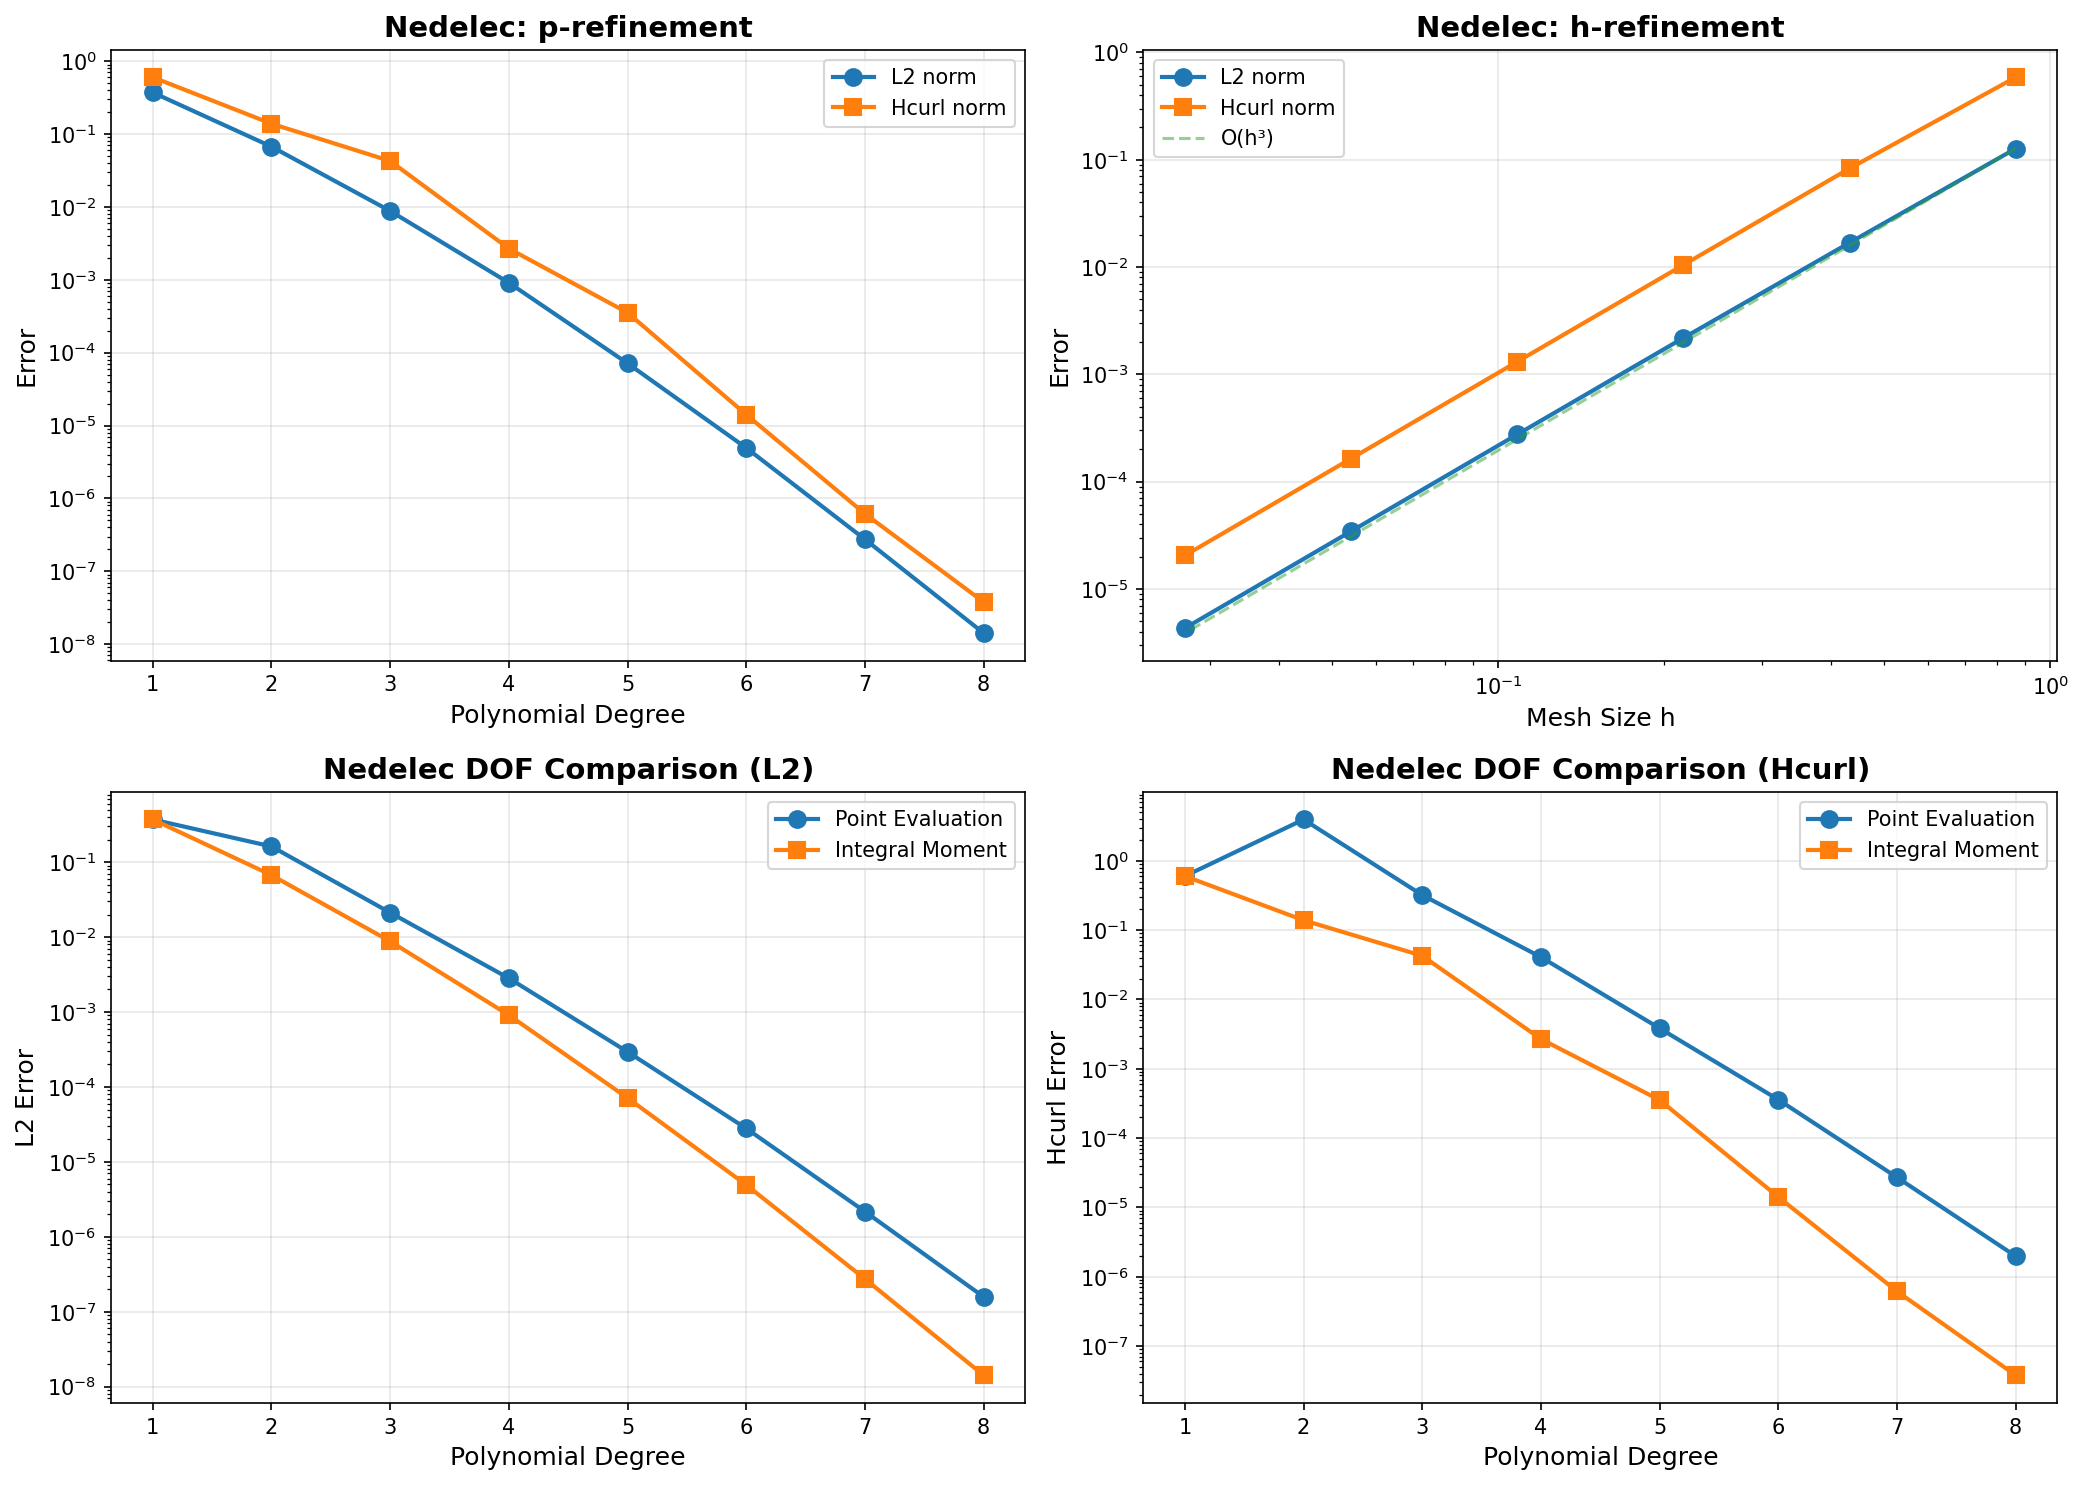

In [ ]:
from IPython.display import Image, display

display(Image('interpolation_errors.png'))